In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = sqlite3.connect('student_performance.db')
cursor = conn.cursor()

In [3]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS academic_records (
    student_id INTEGER PRIMARY KEY,
    gpa FLOAT,
    attendance_rate FLOAT,
    failed_subjects INTEGER
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS socioeconomic_factors (
    student_id INTEGER PRIMARY KEY,
    parent_education INTEGER,  -- 1-5 scale
    family_income INTEGER,     -- 1-5 scale 
    extracurricular INTEGER   -- 0/1
)
''')

In [4]:
np.random.seed(42)
n_students = 1000

In [5]:
academic_data = {
    'student_id': range(n_students),
    'gpa': np.random.normal(3.0, 0.5, n_students).clip(1.0, 4.0),
    'attendance_rate': np.random.uniform(0.6, 1.0, n_students),
    'failed_subjects': np.random.poisson(0.3, n_students)
}

In [6]:
socioeconomic_data = {
    'student_id': range(n_students),
    'parent_education': np.random.randint(1, 6, n_students),
    'family_income': np.random.randint(1, 6, n_students),
    'extracurricular': np.random.binomial(1, 0.4, n_students)
}

In [7]:
academic_df = pd.DataFrame(academic_data)
socioeconomic_df = pd.DataFrame(socioeconomic_data)

In [8]:
academic_df.to_sql('academic_records', conn, if_exists='replace', index=False)
socioeconomic_df.to_sql('socioeconomic_factors', conn, if_exists='replace', index=False)

1000

In [9]:
query = '''
SELECT 
    a.*, 
    s.parent_education, 
    s.family_income, 
    s.extracurricular,
    (a.gpa * a.attendance_rate) AS engagement_score
FROM 
    academic_records a
JOIN 
    socioeconomic_factors s ON a.student_id = s.student_id
'''

df = pd.read_sql(query, conn)

In [12]:
df['at_risk'] = (
    (df['gpa'] < 2.5) | 
    (df['attendance_rate'] < 0.7) | 
    (df['failed_subjects'] > 1)
).astype(int)

In [13]:
df['engagement_score'] = df['gpa'] * df['attendance_rate']

In [14]:
X = df.drop(['student_id', 'at_risk'], axis=1)
y = df['at_risk']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
y_pred = rf.predict(X_test_scaled)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.99
F1 Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       121
           1       0.98      1.00      0.99        79

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



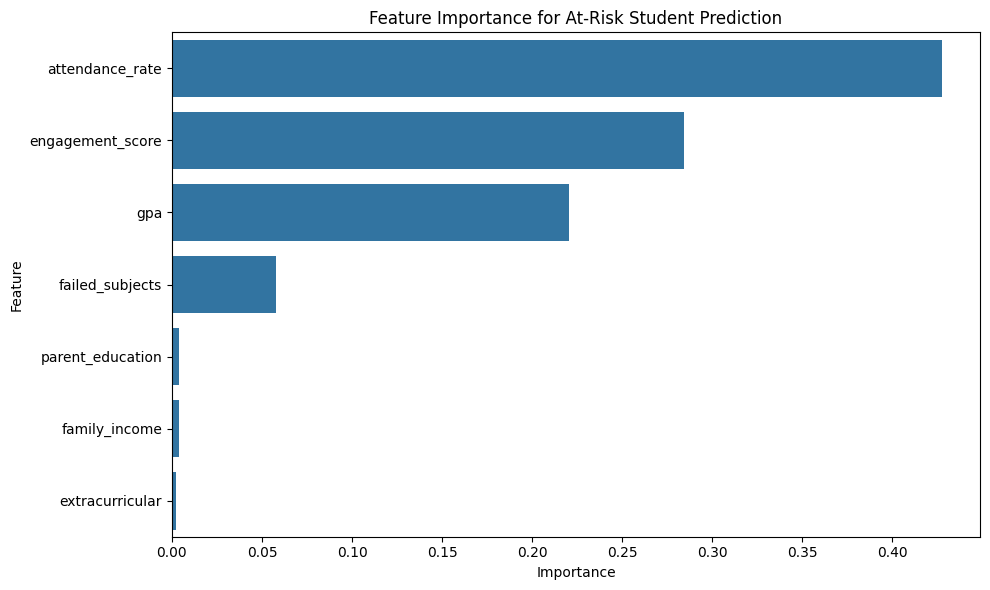

In [20]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for At-Risk Student Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [ ]:
import joblib
joblib.dump(rf, 'models/student_performance_predictor.joblib')
joblib.dump(scaler, 'scaler.joblib')

conn.close()